# HR Analytics: Job Change of Data Scientists


# Gradient Boost Model Performance

| Model              | Accuracy (testing set) | AUC score (testing set) |
| :--                | :--                    |:--                      |
| **Default**        | 0.855                  | 0.925                   |
| **Final Model**    | 0.859                  | 0.936                   |


**Footnote**
- Default model: The model using default hyper parameters.
- Final model: The model with tuned hyper parameters.

# Let's start the  hyper parameter optimization 

## Modules

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# use ggplot in python
from plotnine import *

import os # Set the working directory

pd.set_option('max_colwidth', None) # display all the info in the column. Not to truncate the display.

# Load the processed dataset

Data transformation that I have done:
1. Remove unneeded features
2. Distinguish categorical and continuous variables.
3. Impute missing values
4. Encode "ordinal variables"
5. One hot encode for "Nominal variable"
6. Impute minor outcome
7. Standardize numeric features

In [2]:
from numpy import genfromtxt

os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
X_train_scaled = genfromtxt('X_train_scaled.csv', delimiter=',')
X_test_scaled = genfromtxt('X_test_scaled.csv', delimiter=',')
y_train = genfromtxt('y_train.csv', delimiter=',')
y_test = genfromtxt('y_test.csv', delimiter=',')

In [3]:
# feature name for the transformed X
feature_name = pd.read_csv('X_index.csv')['feature_name']
feature_name

0      city_development_index
1              training_hours
2                   x0_city_1
3                  x0_city_10
4                 x0_city_100
                ...          
148                x5_Pvt Ltd
149           education_level
150                experience
151              company_size
152              last_new_job
Name: feature_name, Length: 153, dtype: object

# Gradient Boost Model - Setup

In [4]:
# Gradient Boost Model
from sklearn.ensemble import GradientBoostingClassifier

# Model evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score

# Plot
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#### Save and read grid search object
import joblib

### Create a function to evaluate model performance
This framework of the function is created by Aarshay Jain. I made a few adjustments for this project.

**reference**: Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [5]:
def modelfit(alg, X_train, y_train, X_test, y_test, 
             feature_name = feature_name,
             performCV=False, 
             printFeatureImportance=True, 
             cv_folds=5):
    
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train) # note: Disbursed is the outcomet/target (y).
        
    #Predict training set:
    train_predictions = alg.predict(      X_train )
    train_predprob    = alg.predict_proba(X_train )[:,1]
    
    #Predict test set:
    test_predictions = alg.predict      (  X_test )
    test_predprob    = alg.predict_proba(  X_test )[:,1]
    
    #Print model report:
    print ("------Training Set-------")
    print ("Model Report")
    print ("Accuracy : %.5g" % accuracy_score(y_train, train_predictions) )
    print ("AUC Score: %.5g" % roc_auc_score( y_train, train_predprob   ) )
    
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validate(alg, X_train, y_train, 
                                  cv=cv_folds, n_jobs=3, 
                                  scoring=['roc_auc','accuracy'])
        # scoring parameter:
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        roc_auc= cv_score['test_roc_auc']
        acc    = cv_score['test_accuracy']
        
        print ("------ CV approach using training set -------")
        
        print ("CV roc_auc : Mean - %.5g | Std - %.5g" %( np.mean(roc_auc), np.std(roc_auc) ) 
              )
        
        print ("CV accuracy: Mean - %.5g | Std - %.5g" %( np.mean(acc), np.std(acc) )
              )
        
    #Print model report:
    print ("------Testing Set-------")
    print ("Model Report")
    print ("Accuracy : %.5g" % accuracy_score(y_test, test_predictions) )
    print ("AUC Score: %.5g" % roc_auc_score( y_test, test_predprob   ) )    
                
    #Print Feature Importance:
    if printFeatureImportance:
        print ("\n")
        print ("------Feature Importance Score based on Training Set-------")
        feat_imp = pd.Series(data= alg.feature_importances_, index= feature_name).sort_values(ascending=False)
        feat_imp_filter = feat_imp[feat_imp> 0.01]
        
        #### Plot
        feat_imp_filter.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# Create a function to find the optimal parameter according to grid search

In [1]:
def fnc_show_best_param(grid_search):
    gsearch = grid_search
    params = np.array( [x for x in gsearch.cv_results_['params']] )
    cv_score = gsearch.cv_results_['mean_test_score']
    my_dict= {'params':params,'cv_score': test_cv_score}
    df = pd.DataFrame(my_dict).sort_values(by='cv_score',ascending=False)
    print(df)

# Baseline GradientBoost
All parameters follow the default.

------Training Set-------
Model Report
Accuracy : 0.86223
AUC Score: 0.9317
------Testing Set-------
Model Report
Accuracy : 0.85538
AUC Score: 0.92505


------Feature Importance Score based on Training Set-------


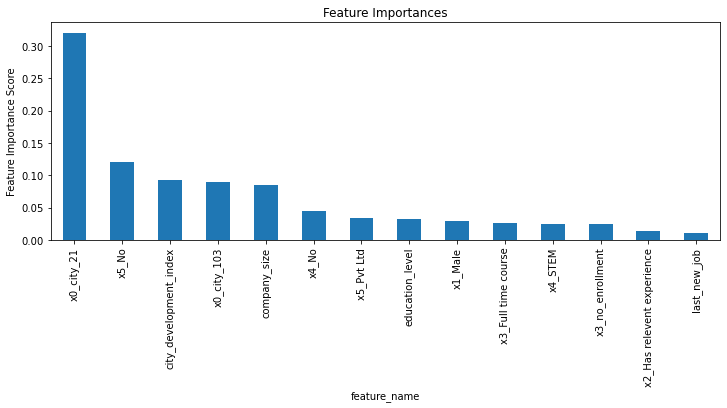

In [7]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train_scaled , y_train, X_test_scaled, y_test)

# Step 1:  Number of estimators at a high learning rate (~0.3)
High learning rate result in a fewer estimators (trees), so the entire training time can be reduced. I use this as initial setting to tune other paramters. In the end, I will reduce learning rate and increase the number of trees, which usually can furter improve the model performance.

In [8]:
#Choose all predictors except target & IDcols
param_test = {'n_estimators':range(30,151,30), 
               'learning_rate': np.arange(0.3, 0.35, 0.01)
              }
gsearch_1 = GridSearchCV(estimator = 
                         GradientBoostingClassifier(
                            # Tuned parameter
                             
                            # Not Tuned
                            learning_rate=0.2, 
                            min_samples_split=150,
                            min_samples_leaf=50,
                            max_depth=8,
                            max_features='sqrt',
                            subsample=0.8,
                            random_state=10), 
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_1.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.2,
                                                  max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=150,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.3 , 0.31, 0.32, 0.33, 0.34]),
                         'n_estimators': range(30, 151, 30)},
             scoring='roc_auc')

In [9]:
#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_1, 'gmb_gsearch_1.pkl')

#### Read grid search results ####
gsearch1 = joblib.load("gmb_gsearch_1.pkl")
fnc_show_best_param(gsearch_1)

                                          params  test_cv_score
8   {'learning_rate': 0.31, 'n_estimators': 120}       0.931135
12   {'learning_rate': 0.32, 'n_estimators': 90}       0.930882
7    {'learning_rate': 0.31, 'n_estimators': 90}       0.930850
6    {'learning_rate': 0.31, 'n_estimators': 60}       0.930633
4    {'learning_rate': 0.3, 'n_estimators': 150}       0.930606
2     {'learning_rate': 0.3, 'n_estimators': 90}       0.930600
1     {'learning_rate': 0.3, 'n_estimators': 60}       0.930543
3    {'learning_rate': 0.3, 'n_estimators': 120}       0.930504
9   {'learning_rate': 0.31, 'n_estimators': 150}       0.930494
11   {'learning_rate': 0.32, 'n_estimators': 60}       0.930423
13  {'learning_rate': 0.32, 'n_estimators': 120}       0.930329
14  {'learning_rate': 0.32, 'n_estimators': 150}       0.930097
22   {'learning_rate': 0.34, 'n_estimators': 90}       0.930083
21   {'learning_rate': 0.34, 'n_estimators': 60}       0.929940
16   {'learning_rate': 0.33, 'n_estimato

# Step 2: Max_depth and min_samples_split


**max_depth**
- The maximum depth of a tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **Intuition:** Higher depth will allow model to learn the pattern which is very specific to a particular sample. Thus, a tree-based model with higher depth tend to be over-fitting. 


**min_samples_split**
- The minimum number of samples required to split into further node. 

- **Intuition:** Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. 


<p> <b> <span style="color:darkred"> NOTE: </span> </b> </p>

**max_depth** and **min_samples_split** are **stop criteria** to prevent a tree from growing too deep. 

In [10]:
param_test = {'max_depth':range(2,16,2), 
              'min_samples_split':range(251,1000, 100)}

gsearch_2 = GridSearchCV(estimator = GradientBoostingClassifier(
                            #Tuned
                            n_estimators=90,
                            learning_rate=0.3,
    
                            #Not Tuned
                            min_samples_leaf=50,
                            max_features='sqrt',
                            subsample=0.8,
                            random_state=10), 
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_2.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.3,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  n_estimators=90,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 16, 2),
                         'min_samples_split': range(251, 1000, 100)},
             scoring='roc_auc')

In [11]:
#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_2, 'gmb_gsearch_2.pkl')

#### Read grid search results ####
gsearch_2 = joblib.load("gmb_gsearch_2.pkl")
fnc_show_best_param(gsearch_2)

                                         params  test_cv_score
28   {'max_depth': 8, 'min_samples_split': 651}       0.931948
37  {'max_depth': 10, 'min_samples_split': 751}       0.931423
47  {'max_depth': 12, 'min_samples_split': 951}       0.931404
33  {'max_depth': 10, 'min_samples_split': 351}       0.931307
24   {'max_depth': 8, 'min_samples_split': 251}       0.931228
46  {'max_depth': 12, 'min_samples_split': 851}       0.931226
38  {'max_depth': 10, 'min_samples_split': 851}       0.931201
53  {'max_depth': 14, 'min_samples_split': 751}       0.931139
40  {'max_depth': 12, 'min_samples_split': 251}       0.931129
31   {'max_depth': 8, 'min_samples_split': 951}       0.931087
25   {'max_depth': 8, 'min_samples_split': 351}       0.931044
26   {'max_depth': 8, 'min_samples_split': 451}       0.931033
43  {'max_depth': 12, 'min_samples_split': 551}       0.931032
29   {'max_depth': 8, 'min_samples_split': 751}       0.931009
32  {'max_depth': 10, 'min_samples_split': 251}       0

# Step 3: min_samples_leaf

**min_samples_leaf** default=1

- The minimum number of samples required to be at a **leaf** or **terminal** node.
- A split point at any depth will only be considered if it has at least min_samples_leaf training samples in each of the left and right branches. 
- This may have the effect of smoothing the model, especially in regression.

<p> <b> <span style="color:darkred"> NOTE: </span> </b> </p>

**min_samples_leaf** is also a **stop criterion** to prevent a tree from growing too deep. 

In [12]:
param_test = {'min_samples_leaf':range(1,100,10)}

gsearch_3 = GridSearchCV(estimator = GradientBoostingClassifier(
                                    #Tuned
                                    n_estimators=90,
                                    learning_rate=0.3,
                                    max_depth= 10,
                                    min_samples_split=851,
    
                                    #Not Tuned
                                    max_features='sqrt',
                                    subsample=0.8,
                                    random_state=10), 
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_3.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.3,
                                                  max_depth=10,
                                                  max_features='sqrt',
                                                  min_samples_split=851,
                                                  n_estimators=90,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=-1, param_grid={'min_samples_leaf': range(1, 100, 10)},
             scoring='roc_auc')

In [13]:
#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_3, 'gmb_gsearch_3.pkl')

#### Read grid search results ####
gsearch_3 = joblib.load("gmb_gsearch_3.pkl")
fnc_show_best_param(gsearch_3)

                     params  test_cv_score
3  {'min_samples_leaf': 31}       0.931775
7  {'min_samples_leaf': 71}       0.931498
8  {'min_samples_leaf': 81}       0.931308
9  {'min_samples_leaf': 91}       0.931128
6  {'min_samples_leaf': 61}       0.931123
5  {'min_samples_leaf': 51}       0.930822
4  {'min_samples_leaf': 41}       0.930709
2  {'min_samples_leaf': 21}       0.930096
1  {'min_samples_leaf': 11}       0.929431
0   {'min_samples_leaf': 1}       0.928878


# Step4: max_features

**Squred root of the number of total predictor** is the good starting point for "max_features". 

In this problem set, I have 153 predictors.

It's reasonable to start the max_features around sqrt of # predictors (12) and upto 50% of the # predictor (76)

In [14]:
print( np.sqrt(X_train_scaled.shape[1]) )
print( X_train_scaled.shape[1]/2 )

12.36931687685298
76.5


In [15]:
param_test = {'max_features':range(5,70,5)}

gsearch_4 = GridSearchCV(estimator = GradientBoostingClassifier(
                                    #Tuned
                                    n_estimators=90,
                                    learning_rate=0.3,
                                    max_depth= 10,
                                    min_samples_split=851,
                                    min_samples_leaf=61,
    
                                    #Not Tuned
                                    max_features='sqrt',
                                    subsample=0.8,
                                    random_state=10), 
                         
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_4.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.3,
                                                  max_depth=10,
                                                  max_features='sqrt',
                                                  min_samples_leaf=61,
                                                  min_samples_split=851,
                                                  n_estimators=90,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=-1, param_grid={'max_features': range(5, 70, 5)},
             scoring='roc_auc')

In [16]:
#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_4, 'gmb_gsearch_4.pkl')

#### Read grid search results ####
gsearch_4 = joblib.load("gmb_gsearch_4.pkl")
fnc_show_best_param(gsearch_4)

                  params  test_cv_score
3   {'max_features': 20}       0.931288
4   {'max_features': 25}       0.931189
1   {'max_features': 10}       0.930678
2   {'max_features': 15}       0.930670
6   {'max_features': 35}       0.930665
7   {'max_features': 40}       0.930569
10  {'max_features': 55}       0.930401
8   {'max_features': 45}       0.930399
5   {'max_features': 30}       0.930310
12  {'max_features': 65}       0.929935
11  {'max_features': 60}       0.929558
9   {'max_features': 50}       0.929558
0    {'max_features': 5}       0.928968


# Step5: Subsample 

subsample with default=1.0 The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.


In [17]:
param_test = {'subsample':np.arange(0.9, 1.0, 0.01) }
gsearch_5 = GridSearchCV(estimator = GradientBoostingClassifier(
                                    #Tuned
                                    n_estimators=90,
                                    learning_rate=0.3,
                                    max_depth= 10,
                                    min_samples_split=851,
                                    min_samples_leaf=61,
                                    max_features=25,
    
                                    #Not Tuned
                                    random_state=10), 
 
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_5.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.3,
                                                  max_depth=10, max_features=25,
                                                  min_samples_leaf=61,
                                                  min_samples_split=851,
                                                  n_estimators=90,
                                                  random_state=10),
             n_jobs=-1,
             param_grid={'subsample': array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])},
             scoring='roc_auc')

In [18]:
#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_5, 'gmb_gsearch_5.pkl')

#### Read grid search results ####
gsearch_5 = joblib.load("gmb_gsearch_5.pkl")
fnc_show_best_param(gsearch_5)

                              params  test_cv_score
2                {'subsample': 0.92}       0.931349
8  {'subsample': 0.9800000000000001}       0.931207
9  {'subsample': 0.9900000000000001}       0.931199
5  {'subsample': 0.9500000000000001}       0.931119
3                {'subsample': 0.93}       0.931078
7  {'subsample': 0.9700000000000001}       0.931065
6  {'subsample': 0.9600000000000001}       0.930974
1                {'subsample': 0.91}       0.930927
0                 {'subsample': 0.9}       0.930615
4  {'subsample': 0.9400000000000001}       0.930253


### subsample is about 0.95. 

# Step 6:  Lower Learning Rate

### Next, we refine learning_rate and n_estimator
Explore a wider range of learning rate around 0.1 and a bit more trees from 120 to 1000.

In [19]:
param_test = {'learning_rate':[0.05, 0.1, 0.2], 'n_estimators': range(200, 1000, 250)}
gsearch_6 = GridSearchCV(estimator = GradientBoostingClassifier(
                                    #Tuned
                                    n_estimators=90,
                                    learning_rate=0.3,
                                    max_depth= 10,
                                    min_samples_split=851,
                                    min_samples_leaf=61,
                                    max_features=25,
                                    subsample=0.95,
    
                                    #Not Tuned
                                    random_state=10), 
                        
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_6.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.3,
                                                  max_depth=10, max_features=25,
                                                  min_samples_leaf=61,
                                                  min_samples_split=851,
                                                  n_estimators=90,
                                                  random_state=10,
                                                  subsample=0.95),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': range(200, 1000, 250)},
             scoring='roc_auc')

In [20]:
#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_6, 'gmb_gsearch_6.pkl')

#### Read grid search results ####
gsearch_6 = joblib.load("gmb_gsearch_6.pkl")
fnc_show_best_param(gsearch_6)

                                          params  test_cv_score
1   {'learning_rate': 0.05, 'n_estimators': 450}       0.932882
4    {'learning_rate': 0.1, 'n_estimators': 200}       0.932648
0   {'learning_rate': 0.05, 'n_estimators': 200}       0.932472
2   {'learning_rate': 0.05, 'n_estimators': 700}       0.932124
3   {'learning_rate': 0.05, 'n_estimators': 950}       0.931306
5    {'learning_rate': 0.1, 'n_estimators': 450}       0.931168
8    {'learning_rate': 0.2, 'n_estimators': 200}       0.930526
6    {'learning_rate': 0.1, 'n_estimators': 700}       0.929932
7    {'learning_rate': 0.1, 'n_estimators': 950}       0.928534
9    {'learning_rate': 0.2, 'n_estimators': 450}       0.927739
10   {'learning_rate': 0.2, 'n_estimators': 700}       0.925963
11   {'learning_rate': 0.2, 'n_estimators': 950}       0.924116


In [21]:
param_test = {'learning_rate':[0.01, 0.03, 0.05], 'n_estimators': range(200, 1000, 250)}
gsearch_6_2 = GridSearchCV(estimator = GradientBoostingClassifier(
                                    #Tuned
                                    n_estimators=90,
                                    learning_rate=0.3,
                                    max_depth= 10,
                                    min_samples_split=851,
                                    min_samples_leaf=61,
                                    max_features=25,
                                    subsample=0.95,
    
                                    #Not Tuned
                                    random_state=10), 
                        
                         param_grid = param_test, 
                         scoring='roc_auc',
                         n_jobs=-1,
                         cv=5)

gsearch_6_2.fit(X_train_scaled,y_train)

#### Save grid search ####
os.chdir('C:/Users/15177/Python_Project/HR_Analysis/Data/')
joblib.dump(gsearch_6_2, 'gmb_gsearch_6_2.pkl')

#### Read grid search results ####
gsearch_6_2 = joblib.load("gmb_gsearch_6_2.pkl")
fnc_show_best_param(gsearch_6_2)

                                          params  test_cv_score
5   {'learning_rate': 0.03, 'n_estimators': 450}       0.933050
6   {'learning_rate': 0.03, 'n_estimators': 700}       0.932985
9   {'learning_rate': 0.05, 'n_estimators': 450}       0.932882
7   {'learning_rate': 0.03, 'n_estimators': 950}       0.932544
3   {'learning_rate': 0.01, 'n_estimators': 950}       0.932539
8   {'learning_rate': 0.05, 'n_estimators': 200}       0.932472
10  {'learning_rate': 0.05, 'n_estimators': 700}       0.932124
2   {'learning_rate': 0.01, 'n_estimators': 700}       0.931653
11  {'learning_rate': 0.05, 'n_estimators': 950}       0.931306
4   {'learning_rate': 0.03, 'n_estimators': 200}       0.930731
1   {'learning_rate': 0.01, 'n_estimators': 450}       0.929068
0   {'learning_rate': 0.01, 'n_estimators': 200}       0.920709


<p> <b> <span style="color:darkred"> NOTE: </span> </b> </p>
Learning rate is reduced to 0.03 with an increased number of trees('n_estimators' = 700). 

# Summary

### Baseline Model

------Training Set-------
Model Report
Accuracy : 0.86223
AUC Score: 0.9317
------Testing Set-------
Model Report
Accuracy : 0.85538
AUC Score: 0.92505


------Feature Importance Score based on Training Set-------


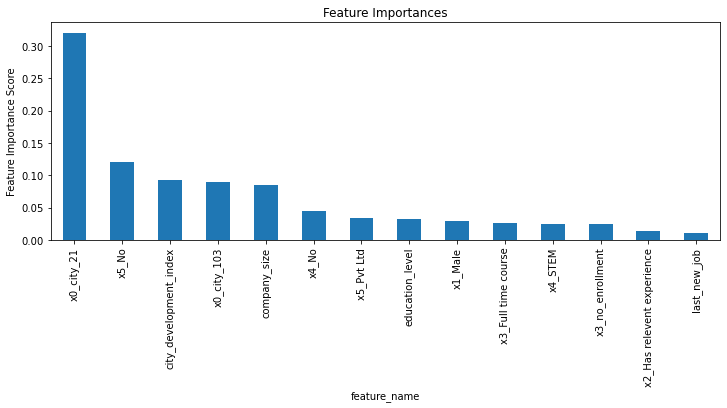

In [22]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train_scaled , y_train, X_test_scaled, y_test)

### Final Model

------Training Set-------
Model Report
Accuracy : 0.87896
AUC Score: 0.94977
------Testing Set-------
Model Report
Accuracy : 0.8599
AUC Score: 0.93614


------Feature Importance Score based on Training Set-------


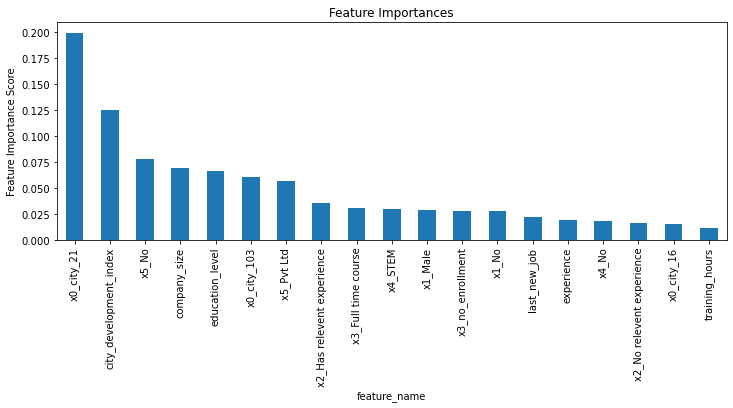

In [23]:
modelfit(gsearch_6_2.best_estimator_, X_train_scaled , y_train, X_test_scaled, y_test)

### Feature importance
based on final model

In [24]:
feature_name = pd.read_csv('X_index.csv')['feature_name']
feature_name

0      city_development_index
1              training_hours
2                   x0_city_1
3                  x0_city_10
4                 x0_city_100
                ...          
148                x5_Pvt Ltd
149           education_level
150                experience
151              company_size
152              last_new_job
Name: feature_name, Length: 153, dtype: object

Text(0, 0.5, 'Feature Importance Score')

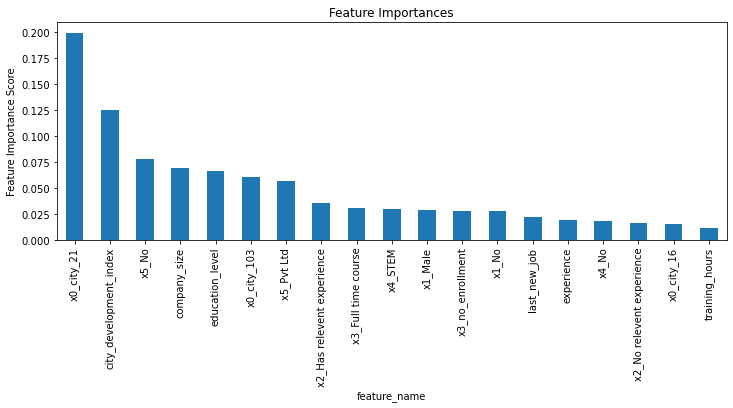

In [25]:
feat_imp = pd.Series(data= gsearch_6_2.best_estimator_.feature_importances_, index= feature_name).sort_values(ascending=False)


#### Filter out less important fatures
feat_imp_filter = feat_imp[feat_imp> 0.01]

#### Plot
feat_imp_filter.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

# End